In [42]:
import torch
import tenseal as ts
import time
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import numpy as np
import pickle
import pandas as pd
import seaborn as sns

In [10]:
def incarcare_date(path):
    date_salvate = torch.load(path,weights_only=True)
    x_train = date_salvate['train_data']
    x_test = date_salvate['test_data']
    y_train = date_salvate['train_labels']
    y_test = date_salvate['test_labels']
    print("############# Data summary #############")
    print(f"x_train has shape: {x_train.shape}")
    print(f"y_train has shape: {y_train.shape}")
    print(f"x_test has shape: {x_test.shape}")
    print(f"y_test has shape: {y_test.shape}")
    print("#######################################")
    return x_train,x_test,y_train,y_test

In [9]:
def normalizare_date(x_train,x_test,y_train,y_test):
    scaler = StandardScaler()
    x_train = torch.tensor(scaler.fit_transform(x_train), dtype=torch.float32)
    x_test= torch.tensor(scaler.transform(x_test), dtype=torch.float32)
    print(x_train.shape)
    print(x_test.shape)
    y_train = torch.tensor(scaler.fit_transform(y_train), dtype=torch.float32)
    y_test = torch.tensor(scaler.transform(y_test), dtype=torch.float32)
    return x_train,x_test,y_train,y_test


In [11]:
x_train,x_test,y_train,y_test = incarcare_date('date_liniar_regression.pth')
x_train,x_test,y_train,y_test = normalizare_date(x_train,x_test,y_train,y_test)
#vom lucra doar cu o parte din setul de date pentru a antrena mai repede modelul, deoarce nu ne intereseaza acuratetea modelului 

############# Data summary #############
x_train has shape: torch.Size([24500, 17])
y_train has shape: torch.Size([24500, 1])
x_test has shape: torch.Size([10500, 17])
y_test has shape: torch.Size([10500, 1])
#######################################
torch.Size([24500, 17])
torch.Size([10500, 17])


In [3]:
class LinearRegressionEncrypted:
    def __init__(self, n_features, learning_rate=1e-2, weight_decay=0.01):
        self.bound = np.sqrt(3/n_features)
        self.weight = np.random.uniform(-self.bound, self.bound, size=n_features).tolist()
        self.bias = np.zeros(1).tolist()
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self._delta_w = 0
        self._delta_b = 0


    def forward_on_encrypted_data(self, enc_x):
        #enc_x este un batch de date, shape : b,n_features
        output = []
        for x in enc_x:
            enc_pred  = x.dot( self.weight) + self.bias
            output.append(enc_pred)
        return output

    def backward(self, enc_x, enc_out, enc_y):
        batch_size = len(enc_x)
        delta_y = [(out - y) for out, y in zip(enc_out, enc_y)]
        delta_w = [ x * dy for dy, x in zip(delta_y, enc_x)]
        self._delta_w = sum(delta_w) * (2/batch_size)
        self._delta_b = sum(delta_y) * (2/batch_size)


    def update_parameters(self):
        if self._delta_w == 0:
            raise RuntimeError("Trebuie sa treci prin functia forword macar o data")
        self._delta_w *= self.learning_rate
        self._delta_w += self.weight_decay * self.weight
        self.weight -= self._delta_w
        self.bias -= self._delta_b * self.learning_rate
        self._delta_w = 0
        self._delta_b = 0

    def encrypt(self, context):
        self.weight = ts.ckks_vector(context, self.weight)
        self.bias = ts.ckks_vector(context, self.bias)
       
    def decrypt(self):
        self.weight = self.weight.decrypt()
        self.bias = self.bias.decrypt()
       

In [6]:
def save_model(model,file_path):
    pickle.dump(model, open(file_path, "wb"))


In [7]:
poly_mod_degree = 8192
coeff_mod_bit_sizes = [40, 21, 21, 21, 21, 21, 21, 40]
ctx_training = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
ctx_training.global_scale = 2 ** 21
ctx_training.generate_galois_keys()

In [8]:

t_start = time.perf_counter()
enc_x_train = [ts.ckks_vector(ctx_training, x.tolist()) for x in x_train[:1000]]
t_end = time.perf_counter()
print(f"Criptarea pe setul de date de train a durat {(t_end - t_start):.20f} secunde")

t_start = time.perf_counter()
enc_y_train = [ts.ckks_vector(ctx_training, x.tolist()) for x in y_train[:1000]]
t_end = time.perf_counter()
print(f"Criptarea pe setul de etichete de train a durat {(t_end - t_start):.20f} secunde")



Criptarea pe setul de date de train a durat 7.93214930000000073562 secunde
Criptarea pe setul de etichete de train a durat 9.96538030000000141229 secunde


In [9]:
model = LinearRegressionEncrypted(x_train.shape[1])

In [10]:

batch_size = 512
t_start = time.perf_counter()
for epoch in tqdm(range(15),desc="epoch"):
    t_start_epoch = time.perf_counter()
    indices = np.random.permutation(len(enc_x_train))
    epoch_data = [enc_x_train[idx] for idx in indices]
    epoch_targets = [enc_y_train[idx] for idx in indices]


    for batch in range(0, len(epoch_data),batch_size):
        model.encrypt(ctx_training)
        batch_data = epoch_data[batch: batch+batch_size]
        batch_targets = epoch_targets[batch: batch+batch_size]

        batch_out = model.forward_on_encrypted_data(batch_data)
        model.backward(batch_data, batch_out, batch_targets)
        model.update_parameters()
        model.decrypt()
    t_end_epoch = time.perf_counter()
    print(f"Epoca {epoch} a durat {(t_end_epoch - t_start_epoch):.20f} secunde")
t_end = time.perf_counter()
print(f"Antrenarea modelului pe date criptate a durat {(t_end - t_start):.20f} secunde")


epoch:   7%|▋         | 1/15 [01:12<16:51, 72.26s/it]

Epoca 0 a durat 72.26090659999999843421 secunde


epoch:  13%|█▎        | 2/15 [02:22<15:26, 71.28s/it]

Epoca 1 a durat 70.58895180000000380005 secunde


epoch:  20%|██        | 3/15 [03:33<14:13, 71.13s/it]

Epoca 2 a durat 70.95763379999999642678 secunde


epoch:  27%|██▋       | 4/15 [04:45<13:04, 71.33s/it]

Epoca 3 a durat 71.62549160000000370019 secunde


epoch:  33%|███▎      | 5/15 [05:56<11:53, 71.39s/it]

Epoca 4 a durat 71.49332420000001775406 secunde


epoch:  40%|████      | 6/15 [07:08<10:43, 71.47s/it]

Epoca 5 a durat 71.62881720000001450899 secunde


epoch:  47%|████▋     | 7/15 [08:20<09:32, 71.52s/it]

Epoca 6 a durat 71.61601090000004887770 secunde


epoch:  53%|█████▎    | 8/15 [09:30<08:18, 71.16s/it]

Epoca 7 a durat 70.39182710000000042783 secunde


epoch:  60%|██████    | 9/15 [10:41<07:05, 70.95s/it]

Epoca 8 a durat 70.47508170000003246969 secunde


epoch:  67%|██████▋   | 10/15 [11:52<05:55, 71.18s/it]

Epoca 9 a durat 71.69126719999997021660 secunde


epoch:  73%|███████▎  | 11/15 [13:04<04:45, 71.40s/it]

Epoca 10 a durat 71.90724439999996775441 secunde


epoch:  80%|████████  | 12/15 [14:15<03:33, 71.24s/it]

Epoca 11 a durat 70.88409030000002530869 secunde


epoch:  87%|████████▋ | 13/15 [15:26<02:22, 71.26s/it]

Epoca 12 a durat 71.29312310000000252330 secunde


epoch:  93%|█████████▎| 14/15 [16:38<01:11, 71.32s/it]

Epoca 13 a durat 71.47266749999994317477 secunde


epoch: 100%|██████████| 15/15 [17:50<00:00, 71.36s/it]

Epoca 14 a durat 72.04765159999999468710 secunde
Antrenarea modelului pe date criptate a durat 1070.35109399999987545016 secunde


In [11]:
save_model(model,"./li_r_trained_on_encrypted_data.pkl")

In [7]:
def forward(model, x_test):
    w = torch.tensor(model.weight)
    b = torch.tensor(model.bias)
    out = (x_test.matmul(w) + b).reshape(-1, 1)
    return out

In [18]:
def metrics_on_clear_test_data(model, x, y):
    t_start = time.perf_counter()
    pred = forward(model,x)
    t_end = time.perf_counter()
    print(f"Predictiile pe testul de date necriptate au durat:{(t_end - t_start):.20f} secunde")

    print(f"Predictii: {pred.shape}")
    print(f"Etichete: {y.shape}")
    y = y.detach().numpy()
    pred = pred.detach().numpy()
    r2 = r2_score(y, pred)
    print(f"R^2 Score = {r2:.4f}")
    mse =  mean_squared_error(y, pred)
    print(f"MSE = {mse:.4f}")

    plt.figure(figsize=(10, 6))
    plt.scatter(y, pred, alpha=0.5, color='darkred', label='Predictii vs. Valori Reale')
    plt.plot([min(y), max(y)], [min(y), max(y)], color='blue', linestyle='--', label='Predictii perfecte')
    plt.xlabel('Valori Reale', fontsize=12)
    plt.ylabel('Predictii', fontsize=12)
    plt.title('Valori Reale vs. Predictii', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title=f'$R^2 = {r2:.4f}$\nMSE = {mse:.4f}', title_fontsize=12)
    plt.savefig("./li_r_trained_on_encrypted_data_predictions_on_clear_data_all_test_dataset.png")
    plt.show()

Predictiile pe testul de date necriptate au durat:0.00021119999996699335 secunde
Predictions: torch.Size([700, 1])
Actual values: torch.Size([700, 1])
R^2 Score = 0.8694
MSE = 0.1349


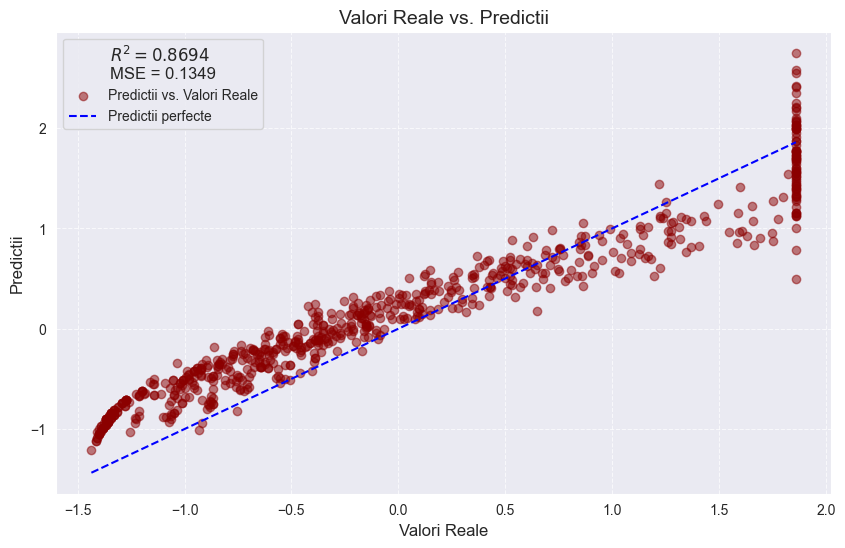

In [16]:
li_r_model = pickle.load(open("./li_r_trained_on_encrypted_data.pkl", 'rb'))
metrics_on_clear_test_data(li_r_model,x_test[:700], y_test[:700])

Incercam pe tot setul de date de test
Predictiile pe testul de date necriptate au durat:0.00068490000001020235 secunde
Predictii: torch.Size([10500, 1])
Etichete: torch.Size([10500, 1])
R^2 Score = 0.8544
MSE = 0.1469


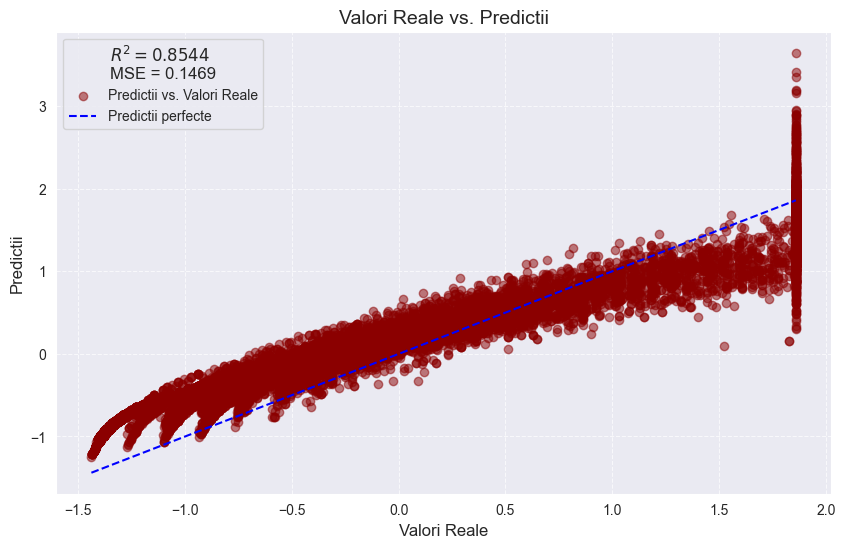

In [20]:
print("Incercam pe tot setul de date de test")
metrics_on_clear_test_data(li_r_model,x_test, y_test)

facem predictii pe setul de date de test criptat

In [24]:
# parameters
poly_mod_degree = 4096
coeff_mod_bit_sizes = [40, 20, 40]
# create TenSEALContext
ctx_eval = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
# scale of ciphertext to use
ctx_eval.global_scale = 2 ** 20
# this key is needed for doing dot-product operations
ctx_eval.generate_galois_keys()

In [35]:
def criptatea_datelor(ctx_eval,nr=0):
    t_start = time.perf_counter()
    if nr !=0:
        enc_x_test = [ts.ckks_vector(ctx_eval, x.tolist()) for x in x_test[:nr]]
    else:
        enc_x_test = [ts.ckks_vector(ctx_eval, x.tolist()) for x in x_test]
    t_end = time.perf_counter()
    print(f"Criptarea pe setul de date de test a durat {(t_end - t_start):.20f} secunde")

    return enc_x_test


In [30]:
def forward_on_encrypted_test_data(model,enc_x):
    enc_pred = enc_x.dot(model.weight)+model.bias
    return enc_pred

In [37]:
def metrici_date_test_criptate(model, enc_x, y):
    #predictiile sunt se vor intoarce criptate
    enc_list_pred = []
    t_start = time.perf_counter()
    for e_x in enc_x:
        pred = forward_on_encrypted_test_data(model,e_x)
        enc_list_pred.append(pred)
    t_end = time.perf_counter()
    print(f"Predictiile pe testul de date criptat au durat:{(t_end - t_start):.20f} secunde")

    #trebuie decriptate pentru a calcula metricile
    list_pred = []
    t_start = time.perf_counter()
    for enc_pred in enc_list_pred:
        decript = enc_pred.decrypt()
        list_pred.append(decript)
    t_end = time.perf_counter()
    print(f"Decriptarea predictiilor a durat:{(t_end - t_start):.20f} secunde")

    y = y.detach().numpy()
    r2 = r2_score(y, list_pred)
    print(f"R^2 Score = {r2:.4f}")
    mse =  mean_squared_error(y, list_pred)
    print(f"MSE = {mse:.4f}")

    plt.figure(figsize=(10, 6))
    plt.scatter(y, list_pred, alpha=0.5, color='darkred', label='Predictii vs. Valori Reale')
    plt.plot([min(y), max(y)], [min(y), max(y)], color='blue', linestyle='--', label='Predictii perfecte')
    plt.xlabel('Valori Reale', fontsize=12)
    plt.ylabel('Predictii', fontsize=12)
    plt.legend(title=f'$R^2 = {r2:.4f}$\nMSE = {mse:.4f}', title_fontsize=12)
    plt.title('Valori Reale vs. Predictii', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig("./li_r_trained_on_encrypted_data_predictions_on_encrypted_data_all_test_data.png")
    plt.show()
  
    

Criptarea pe setul de date de test a durat 1.46865460000003622554 secunde
Predictiile pe testul de date criptat au durat:1.73244880000015655241 secunde
Decriptarea predictiilor a durat:0.10111329999995177786 secunde
R^2 Score = 0.9014
MSE = 0.1020


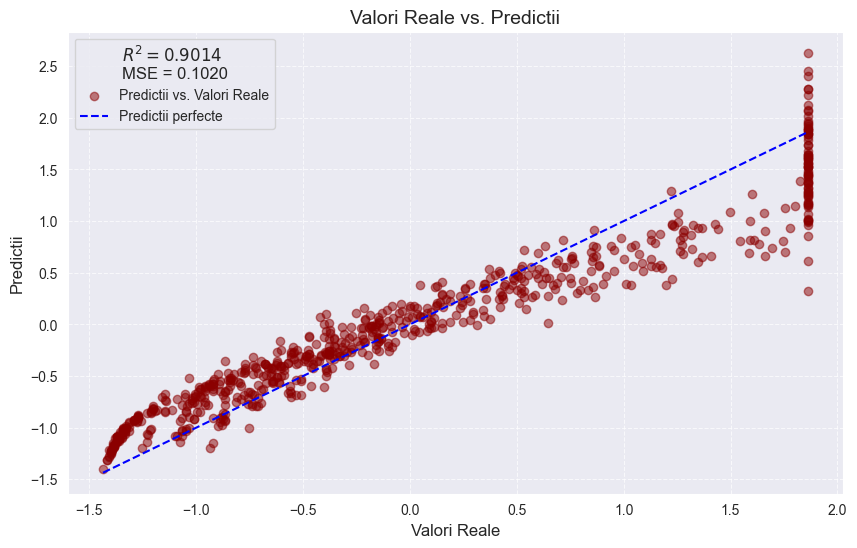

In [36]:
enc_x_test = criptatea_datelor(ctx_eval,700)
metrici_date_test_criptate(li_r_model,enc_x_test,y_test[:700])

Criptarea pe setul de date de test a durat 20.41183200000000397267 secunde
Predictiile pe testul de date criptat au durat:30.32835219999992659723 secunde
Decriptarea predictiilor a durat:1.49744880000002922316 secunde
R^2 Score = 0.8820
MSE = 0.1190


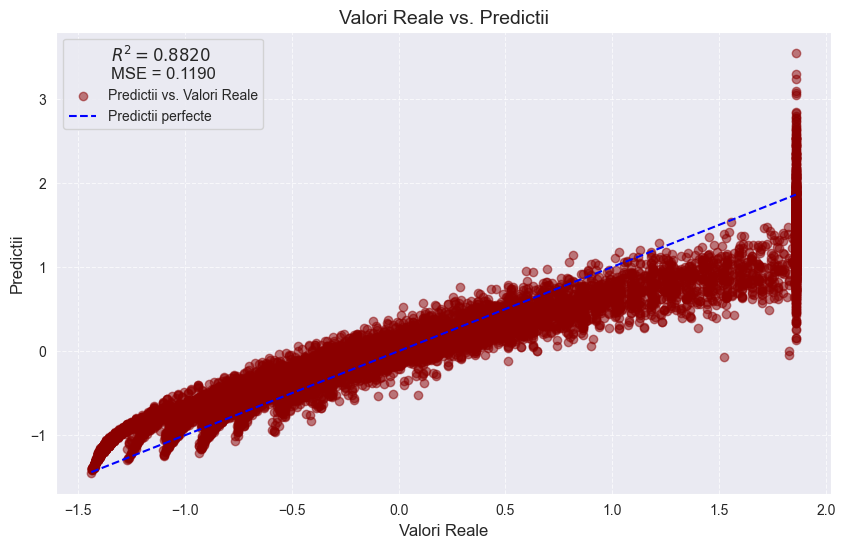

In [38]:
enc_x_test = criptatea_datelor(ctx_eval)
metrici_date_test_criptate(li_r_model,enc_x_test,y_test)

vrem sa vedem daca importanta caracteristicilor pentru un model antrenat pe date criptate se schimba

In [45]:
def importanta_caracteristicilor(model, feature_names):
    weights = model.weight

    weights = np.abs(weights)
    weights = weights / np.sum(weights)

    sorted_indices = np.argsort(weights)
    feature_names_sorted = np.array(feature_names)[sorted_indices]
    weights_sorted = weights[sorted_indices]

    plt.figure(figsize=(16, 6))
    sns.barplot(y=feature_names_sorted, x=weights_sorted, hue=feature_names_sorted, palette="Reds", orient="h", legend=False)

    plt.xlabel('Importanța caracteristicilor', fontsize=12)
    plt.ylabel('Caracteristici', fontsize=12)
    plt.title('Grafic de importanța caracteristicilor', fontsize=14)

    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig("./li_r_trained_on_clear_encrypted_data_feature_importance.png")
    plt.show()



17


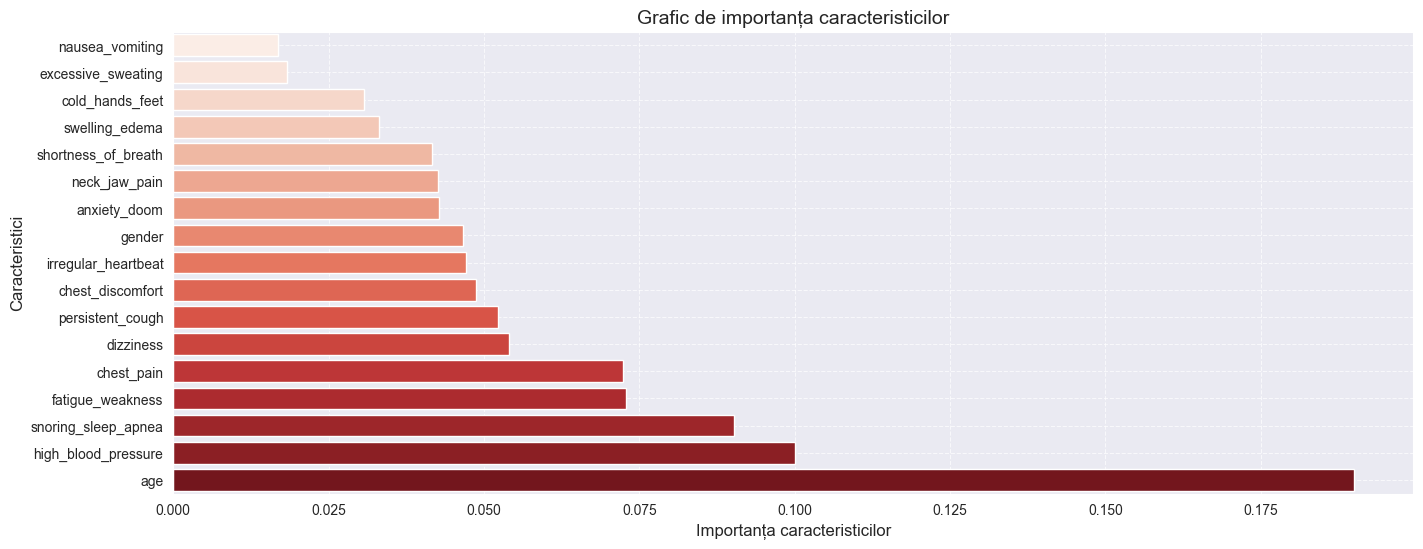

In [46]:
csv = pd.read_csv('./stroke_risk_dataset.csv')
csv = csv.drop(columns=["stroke_risk_percentage", "at_risk"])
header = csv.columns.tolist()
print(len(header))
importanta_caracteristicilor(li_r_model,header) 

se pare ca importanta caracteristicilor se schimba